# Jumping on the latest trend
A look at trending youtube video statistics for GB users

We will be looking at data from Kaggle: https://www.kaggle.com/datasnaek/youtube-new
- This is a collection of the videos that appeared on the trending page on Youtube
- Becoming trending means that in a short time-frame, people are viewing and interacting with your video; and Youtube thinks: "other people might like this".
- But is that all there is to it?


## Let us get right into it

In [2]:
#Load in all the libraries
import datetime
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load in the files

In [3]:
videos_path = "C:/Users/chris/Desktop/youtube-new/GBvideos.csv"
df = pd.read_csv(videos_path)

categories_path = "C:/Users/chris/Desktop/youtube-new/GB_category_id.json"
f=open(categories_path, "r")
parsed_json = (json.loads(f.read()))

# Wrangle some data - replacing the category id with something more verbose
categories_lookup = {"id":[], "title":[]}
for i in range(len(parsed_json["items"])):
    categories_lookup["id"].append(parsed_json["items"][i]["id"])
    categories_lookup["title"].append(parsed_json["items"][i]["snippet"]["title"])

category_lookup = pd.DataFrame(categories_lookup)
category_lookup.set_index("id", inplace=True)

categ_dict = category_lookup.to_dict('dict')['title']
df["category_id"] = df["category_id"].astype(str)
df["category_id"].replace(categ_dict, inplace=True)

In [4]:
### Let's have a look at the data in general
print("Total rows: "+ str(df['video_id'].describe()[0]))
print("Unique Videos: "+ str(df['video_id'].describe()[1]))
print("Top Occuring Category: " + str(df['category_id'].describe()[2]) + " with " + str(df['category_id'].describe()[3]) + " rows")
print("Top Occuring Channel: " + str(df['channel_title'].describe()[2]) + " with " + str(df['channel_title'].describe()[3]) + " rows")

Total rows: 38916
Unique Videos: 3272
Top Occuring Category: Music with 13754 rows
Top Occuring Channel: The Tonight Show Starring Jimmy Fallon with 208 rows


We have roughly 3300 unique videos in this list, but the full table has 39000 rows.  
Corroborating that a video can exist on the trending video for multiple days.

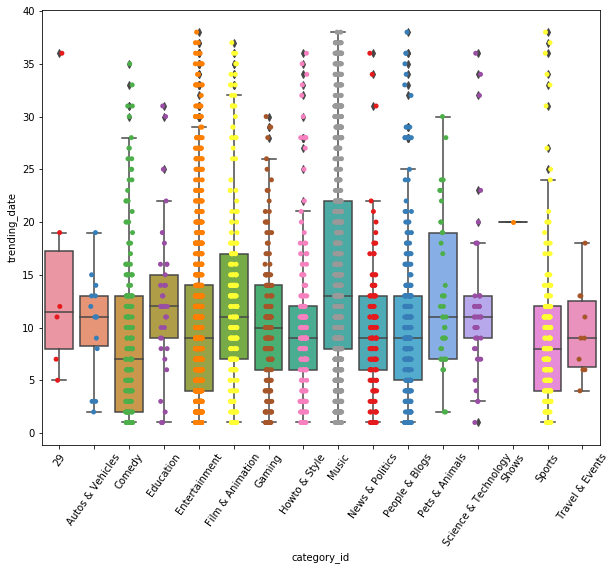

In [5]:
ttt = df.groupby(by=["category_id","video_id"]).count().reset_index()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x="category_id", y="trending_date", data=ttt)
ax = sns.stripplot(x="category_id", y="trending_date", data=ttt,jitter=True,palette='Set1',dodge=True, orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation=55);

It appears that the average number of days a video trends for is at around 8-9 days, with certain categories like Music, Film & Animation as well as Pets & Animals staying trending for longer typically

In [6]:
#Between November 2017 and June 2018
top_trending = list(ttt.sort_values(by="trending_date", ascending=False).head(5)['video_id'])
print("Top 5 Videos that trended the longest")
print(df[df['video_id'].isin(top_trending)]['title'].unique())

Top 5 Videos that trended the longest
['To Our Daughter'
 'Jurassic World: Fallen Kingdom - Official Trailer #2 [HD]'
 'Justin Timberlake’s FULL Pepsi Super Bowl LII Halftime Show! | NFL Highlights'
 'Miguel - Come Through and Chill ft. J. Cole, Salaam Remi'
 'Miguel - Come Through and Chill (Official Video) ft. J. Cole, Salaam Remi'
 'Anne-Marie - 2002 [Official Video]']


In [7]:
# Lets separate out videos that trended for multiple days, and all unique video_ids
duplicates_df = df[df.duplicated(subset="video_id", keep=False)].sort_values(by='title')

# All unique video IDs
uniques_df = df.drop_duplicates(['video_id'],keep='last')

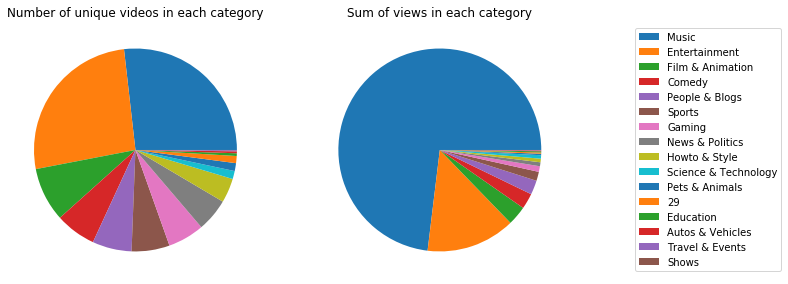

In [8]:
# Number of each category
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,8))

category_count = uniques_df[["category_id","title","description"]].groupby(by="category_id").count().sort_values(by="title", ascending=False).copy()
plt.subplot(1,2,1)
plt.pie(category_count["title"])
plt.title('Number of unique videos in each category')

df_grouped_sum = uniques_df.groupby(by="category_id").sum().sort_values(by=["views", "likes","comment_count"], ascending=False).copy()
plt.subplot(1,2,2)
plt.pie(df_grouped_sum["views"])
plt.legend(df_grouped_sum.index,loc='center left', bbox_to_anchor=(1.25, 0.5))
plt.title('Sum of views in each category')
plt.show()

Lowest view count is: Mountain Bikers Worried About Military Land Being Fenced Off with 1014 views
Highest view count is: Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon with 424538912 views


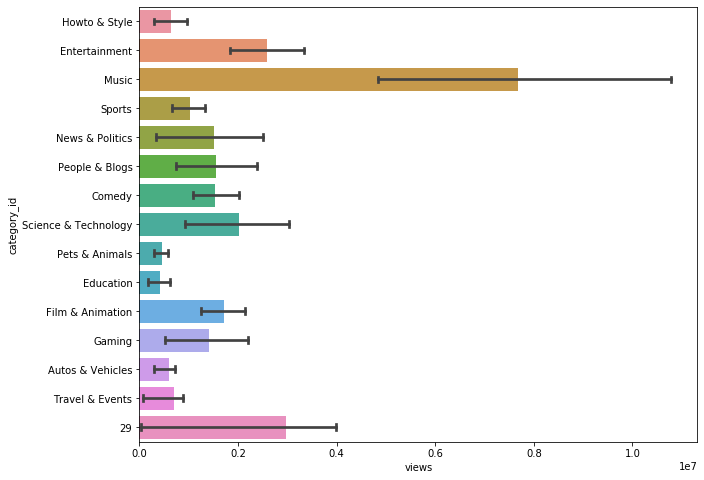

In [9]:
# What about the lowest viewed trending videos?
least_viewed = uniques_df[["title","channel_title","views","likes","dislikes","comment_count"]].sort_values(by="views").head(1)
most_viewed = uniques_df[["title","channel_title","views","likes","dislikes","comment_count"]].sort_values(by="views").tail(1)
print("Lowest view count is: " 
      + list(least_viewed['title'])[0] + " with "  
      + str(list(least_viewed['views'])[0]) + " views")

print("Highest view count is: " 
      + list(most_viewed['title'])[0] + " with "  
      + str(list(most_viewed['views'])[0]) + " views")

uniques_first_df = df.drop_duplicates(['video_id'],keep='first')

fig, ax = plt.subplots(figsize=(10,8))
b = sns.barplot(y='category_id',x='views',data=uniques_first_df,estimator=np.std,orient="h",capsize=.2)
plt.show()

### For the majority of categories, the average view counts sit below the 1 million mark. Indicating that your video is perhaps less likely to go 'trending' unless it's involved in music or entertainment in some way
- On the other hand, it may also suggest that your chances of showing up on trending may be easier with a lower view count if you submit your video in Howto & Style or Pets & Animals

### Lets look at this from a channel by channel process

In [10]:
channel_conversion =[]
for channel in uniques_df['channel_title'].unique():
    obj={}
    subdf = uniques_df[uniques_df['channel_title'] == channel]
    category = subdf['category_id'].max()
    video_count = subdf['video_id'].count()
    views = subdf['views'].sum()
    view_ratio = views/video_count
    comments = subdf['comment_count'].sum()
    likes = subdf['likes'].sum()
    dislikes = subdf['dislikes'].sum()
    like_ratio = likes-dislikes
    obj = {'channel_title':channel, 'category':category,'views':views, 'video_count':video_count,'view_ratio':view_ratio,'comment_count':comments,'likes':likes,'dislikes':dislikes,'netlikes':like_ratio}
    channel_conversion.append(obj)

cc = pd.DataFrame(channel_conversion)
cc['view_ratio'] = cc['view_ratio'].astype(int)
cc.sort_values(by='view_ratio', ascending=False).head(3)

,channel_title,category,views,video_count,view_ratio,comment_count,likes,dislikes,netlikes
1470,Flow La Movie,Music,337621571,1,337621571,113564,2581961,166549,2415412
1282,Bad Bunny,Music,328860380,1,328860380,225216,3823879,215530,3608349
1542,ChildishGambinoVEVO,Music,259721696,1,259721696,553371,5444541,379862,5064679


#### The Music Category absolutely dominates, with single videos pulling in millions of views. And this is as expected as this kind of fame isn't made on youtube alone, alternative media sources/ fan generation lead them here

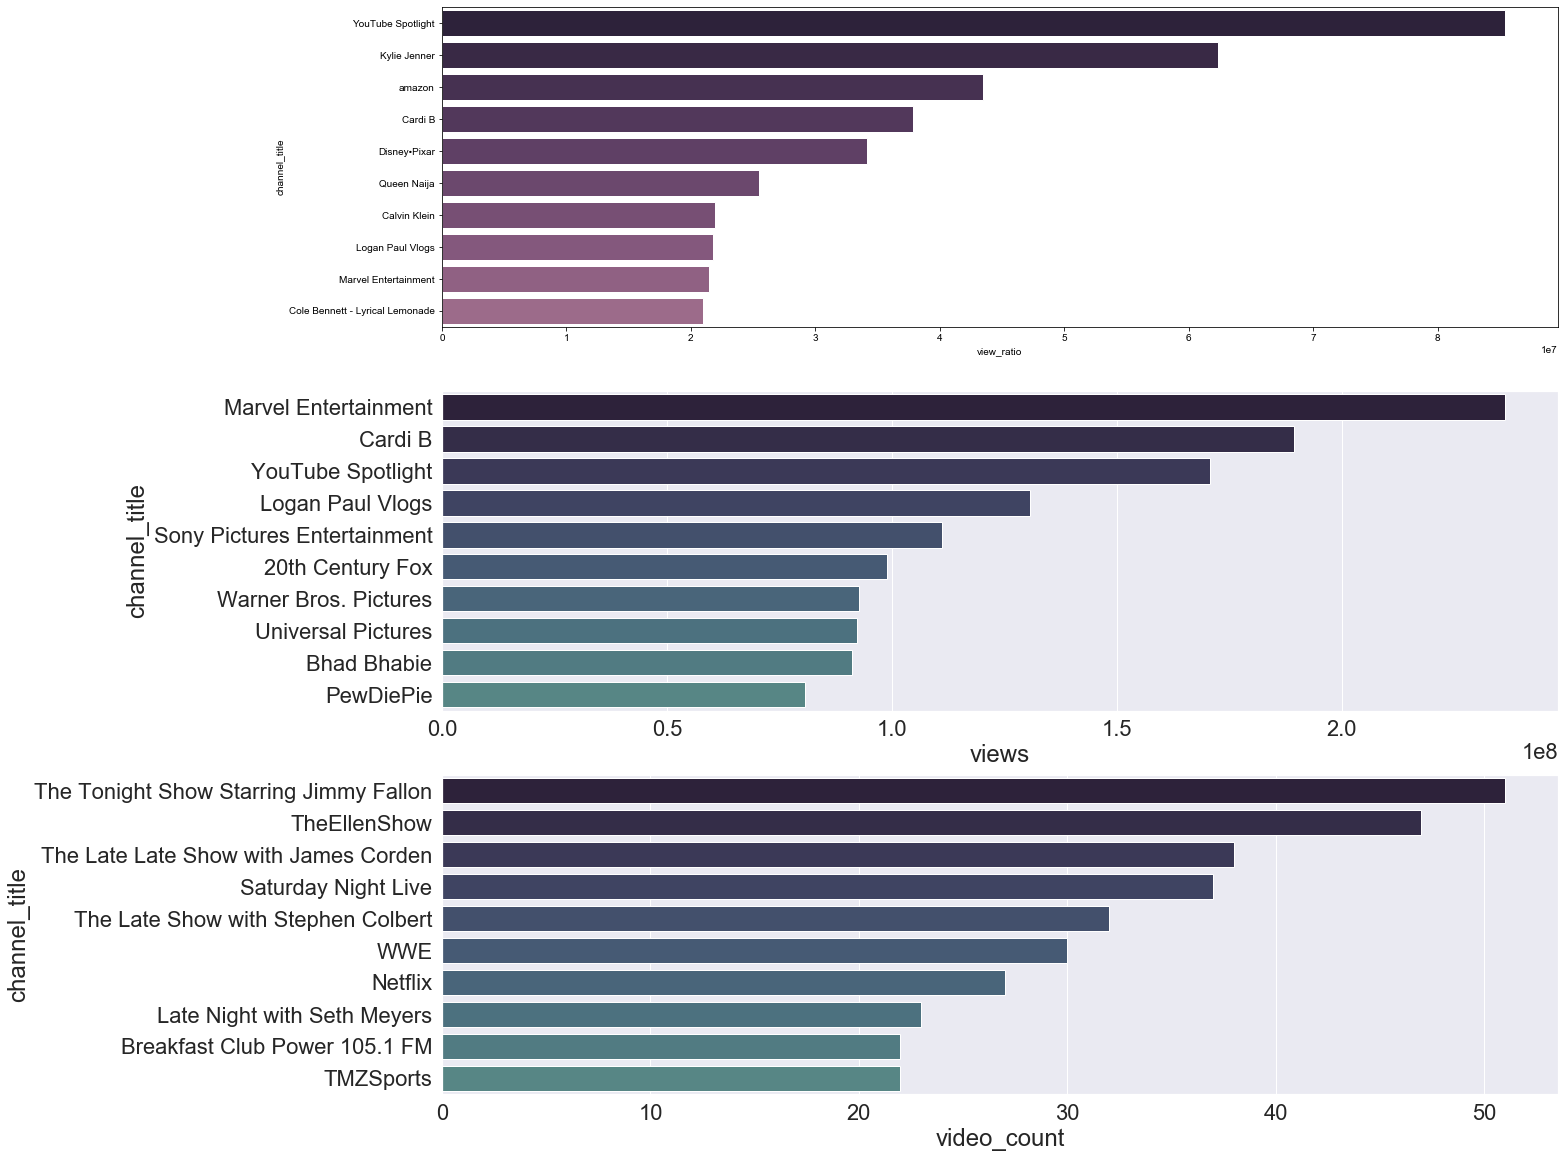

In [11]:
#What about non Music folk?

#Looking at the average views per video that has trended
cdf =cc[cc['category']!="Music"].sort_values(by='view_ratio', ascending=False).head(10)
# Kylie Jenner, Cardi B (well, she could be argued as musical), and Logan Paul are names that I'm somewhat familiar with.

fig, ax = plt.subplots(3,1,figsize=(20,20))

plt.subplot(3,1,1)
sns.set_palette("husl")
sns.set(font_scale = 2)
sns.barplot(x="view_ratio", y="channel_title", data=cdf, palette=sns.cubehelix_palette(n_colors=20, reverse=True))


#Looking at raw views of each channel changes the ordering around, 
vco = cc[cc['category']!="Music"].sort_values(by='views', ascending=False).head(10)
plt.subplot(3,1,2)
sns.set(font_scale = 2)
sns.barplot(x="views", y="channel_title", data=vco,palette=sns.cubehelix_palette(n_colors=20, reverse=True, start=.5, rot=-.75))


vvo = cc[cc['category']!="Music"].sort_values(by='video_count', ascending=False).head(10)
plt.subplot(3,1,3)
sns.set(font_scale = 2)
sns.barplot(x="video_count", y="channel_title", data=vvo,palette=sns.cubehelix_palette(n_colors=20, reverse=True, start=.5, rot=-.75))
plt.show();

### What do we think?
- In all likelihood, for larger corporations it's all about getting as many clips out there as possible. Making sure the branding exists.
- Whereas you begin to see individual tubers when looking at view counts of trending videos, perhaps because loyal fans watch each and every video.
- The results are odd to me though, as it suggests that the algorithm may favour certain channels despite the lack of engagement.
- Of course we can't say anything definitively here as the dataset is only comprised of videos that did trend.
- However, I do know PewDiePie uploads every single day with consistent views and comments, it's odd that he does not have more appearances.

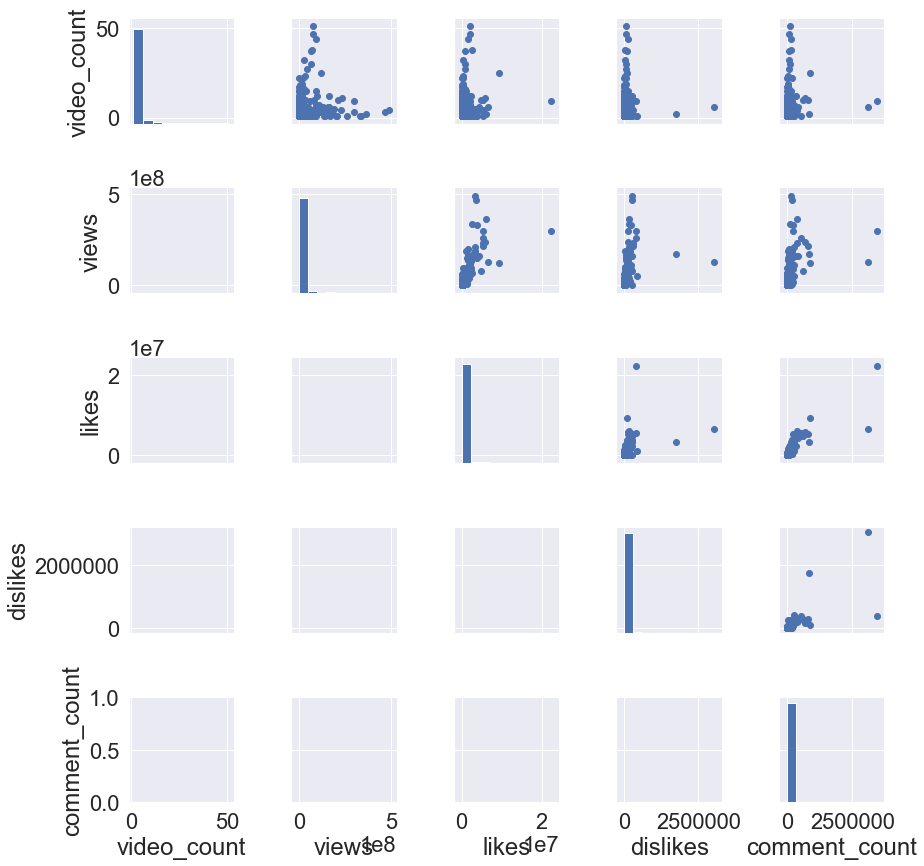

In [12]:
g = sns.PairGrid(cc[["video_count","views","likes","dislikes","comment_count"]])
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
plt.show();

### This is a pairplot, the cheekiest way of visualizing regression and outliers
- It would make sense to log() the variables prioor to visualizing, as some channels skew the trends. But from looking briefly above, there 2 or 3 channels that are highly controversial.  
- Greater than 1 video on trending, yet highly disliked, who are they?

In [13]:
cc.sort_values(by="dislikes", ascending=False).head(1)["channel_title"]

643    Logan Paul Vlogs
Name: channel_title, dtype: object

### I believe this was during Logan Paul's incident regarding the Japanese Suicide forest. So it is no surprise that he raked up several dislikes seeping across all of his uploads on his channel.

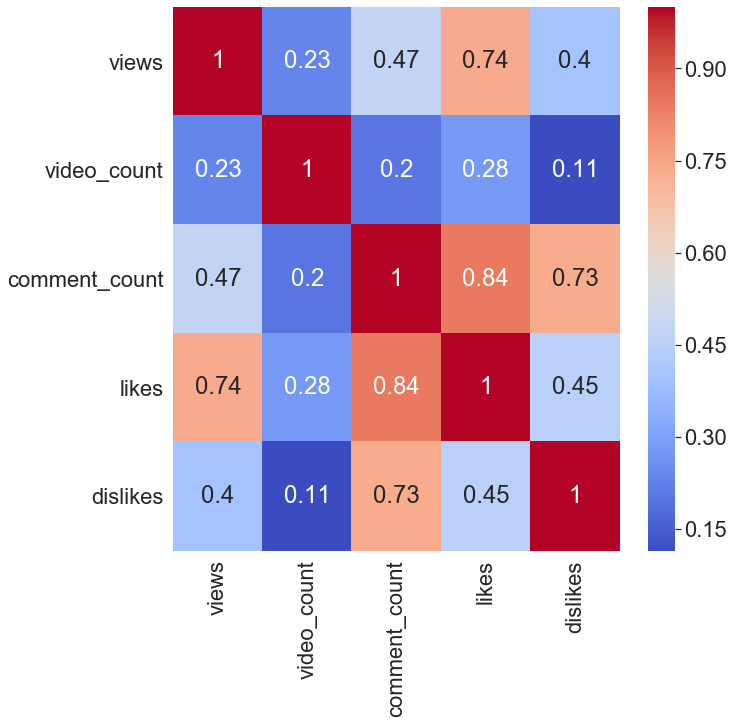

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cc.drop(["view_ratio", "netlikes"], axis=1).corr(),cmap='coolwarm',annot=True)
ax.set_ylim(5.0, 0)
plt.show();

### Another view at regression, although no regression is particularly strong: people apparently tend to comment on videos that they liked. This is a slightly stronger correlation than commenting when they dislike a video.  
Another perspective is also that a highly disliked video is less likely to have more views than a liked one. - Thankfully logic prevails

In [15]:
# Does the proportion of videos in each category change across the year?
def trending_date_format(date):
    split_date = date.split(".")
    cleaned_date = "/".join([split_date[1],split_date[2],split_date[0]])
    return cleaned_date

df['trending_date'] = df['trending_date'].apply(trending_date_format)
df["trend_month"] = df['trending_date'].apply(lambda x: x[3:5])
df["trend_year"] =df['trending_date'].apply(lambda x: x[6:8])

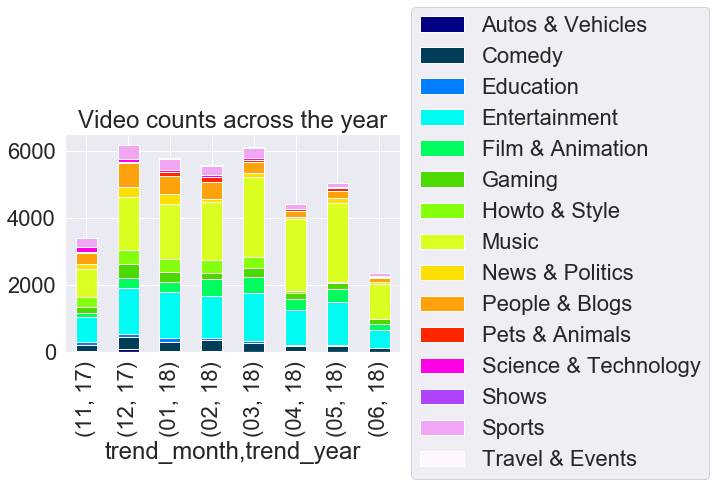

In [16]:
grouped_count = df.groupby(by=["trend_month","trend_year","category_id"]).count().sort_values(by=["trend_year", "trend_month","video_id"]).copy()
ax = grouped_count["video_id"].unstack().fillna(0).astype(int).sort_values(by=["trend_year","trend_month"]).drop(columns="29").copy()
ax.plot.bar(stacked=True,colormap='gist_ncar')
plt.title('Video counts across the year')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show();

As November 2017 and June 2018 are 'half months' we can ignore them for the time being.  
For all videos including multi-day trending ones - generally was see that the proportion of categories stay relatively similar across the winter, but come March - May, Music dominates the trending page even more.

In [17]:
uniques_df['trending_date'] = uniques_df['trending_date'].apply(trending_date_format)
uniques_df["trend_month"] = uniques_df['trending_date'].apply(lambda x: x[3:5])
uniques_df["trend_year"] =uniques_df['trending_date'].apply(lambda x: x[6:8])

C:\Users\chris\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\chris\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chris\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

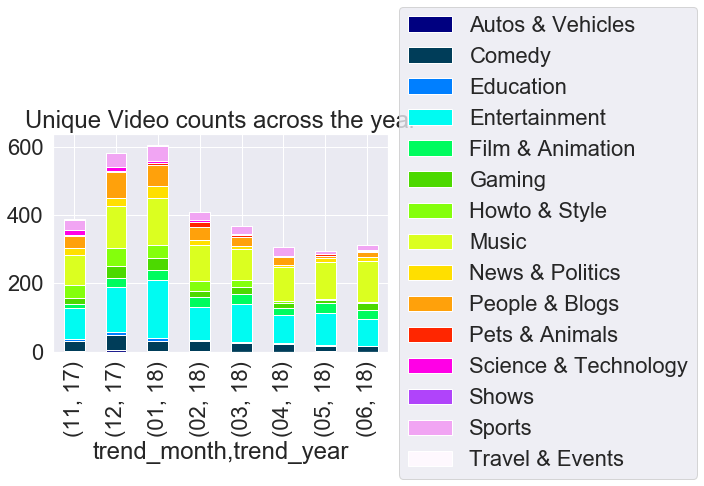

In [18]:
unique_group = uniques_df.groupby(by=["trend_month","trend_year","category_id"]).count().sort_values(by=["trend_year", "trend_month","video_id"]).copy()
ax = unique_group["video_id"].unstack().fillna(0).astype(int).sort_values(by=["trend_year","trend_month"]).drop(columns="29").copy()
ax.plot.bar(stacked=True,colormap='gist_ncar')
plt.title('Unique Video counts across the year')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show();

Filtering for unique videos in each month, we see an increase in unique videos hitting the trend page during the New Years, in particular in the Entertainment category.  
This flattens out from February onwards suggesting a lack of day-to-day changes in trending videos.
NOTE: for video that trended across months, they may be counted twice.

# It wouldn't be a data analysis project without some Machine Learning would it?

- Some possible avenues of applied "A.I" could be a look at the tags, can we predict the category of the video based on the tags?
- Can we predict the category from the thumbnail alone?  
While I wish I can do the latter - none of the thumbnail links work, so lets predict via tags shall we?

Reference:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [46]:
df = uniques_df[["title","tags","description","category_id"]].copy()

#Brief look at all the text we can work with. We will be looking to combine these and clean the data as much as possible.
#From a brief analysis, the descriptions of the videos do not tend to describe much of anything to its irony. It is mostly used to further branding and social media presence.

df["tags"] = df["tags"].apply(lambda x: " " + x)

df["corpus"] = df["title"] + df["tags"]
df.drop(["title","tags","description"], axis=1, inplace=True)

In [47]:
#Initial Clean
df["corpus"] = df["corpus"].apply(lambda x: x.replace("|"," ").replace("\"", ""))

In [48]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [51]:
df.rename(columns={"category_id":"category"}, inplace=True)

#Assign numerical values to distinct items
df['_id'] = df['category'].factorize()[0]

#Create a lookup table based on the unique categories
category_id_df = df[['category', '_id']].drop_duplicates().sort_values('_id')

#Create a dictionary for easy manipulation
category_to_id = dict(category_id_df.values)

#Inverted lookup table
id_to_category = dict(category_id_df[['_id', 'category']].values)

#Lets find the Term Frequency Inverse Document Frequency 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.corpus).toarray()
labels = df._id
features.shape

(3272, 4882)

In [54]:
#Set the number of example Ngrams we wish to retrieve
N = 2

# For each category and associated text
for corpus, category in sorted(category_to_id.items()):
    
    #Run the Chi^2 Test to find the expected and outcome features (N Grams)
    features_chi2 = chi2(features, labels == category)
    
    indices = np.argsort(features_chi2[0])
    #Extract the features (N Grams) from out tfidf transformer using the indices given the category
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("\nIn Category '{}':".format(corpus))
    print(" Most correlated unigrams:  {}".format(', '.join(unigrams[-N:])))
    print(" Most correlated bigrams:  {}".format(', '.join(bigrams[-N:])))


In Category '29':
 Most correlated unigrams:  path, lives
 Most correlated bigrams:  hot topics, march lives

In Category 'Autos & Vehicles':
 Most correlated unigrams:  crash, porsche
 Most correlated bigrams:  star lord, bowl commercial

In Category 'Comedy':
 Most correlated unigrams:  nbc, fallon
 Most correlated bigrams:  funny talk, television funny

In Category 'Education':
 Most correlated unigrams:  language, education
 Most correlated bigrams:  didn know, new hope

In Category 'Entertainment':
 Most correlated unigrams:  ellen, late
 Most correlated bigrams:  ellen degeneres, late late

In Category 'Film & Animation':
 Most correlated unigrams:  movie, trailers
 Most correlated bigrams:  movieclips trailers, trailer 2018

In Category 'Gaming':
 Most correlated unigrams:  ps4, gameplay
 Most correlated bigrams:  video game, nintendo switch

In Category 'Howto & Style':
 Most correlated unigrams:  makeup, beauty
 Most correlated bigrams:  maria sammi, samantha maria

In Catego

In [58]:
# Lets compare different Machine Learning Techniques

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [65]:
# Lets try to train a Naive Bayesiuan Multinomial Classifier to see if we get accurate predictions

X_train, X_test, y_train, y_test = train_test_split(df['corpus'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [63]:
print(clf.predict(count_vect.transform(["Definitely NOT CLICKBAIT"])))

['Entertainment']


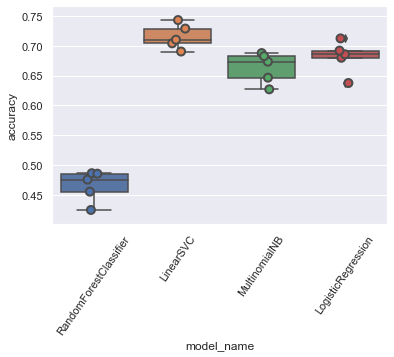

In [71]:
# What about the other methods?
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

#Load up all the methods into an iterable list
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

#Initialise a dataframe to hold our results
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

#Grab the accuracies across the models, running each 5 times to get averages
for model in models:
    model_name = model.__class__.__name__
    
    #Using cross validation score method, grab the accuracies using the features and labels we created before
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Lets try plotting it out
sns.set(font_scale = 1)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
ax = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=55);
plt.show();

## Our NB model seemed to work pretty good, but it appears Linear SVC works a tad better, so lets look in depth at its accuracies across categories

In [73]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.715289
LogisticRegression        0.681401
MultinomialNB             0.663383
RandomForestClassifier    0.465337
Name: accuracy, dtype: float64

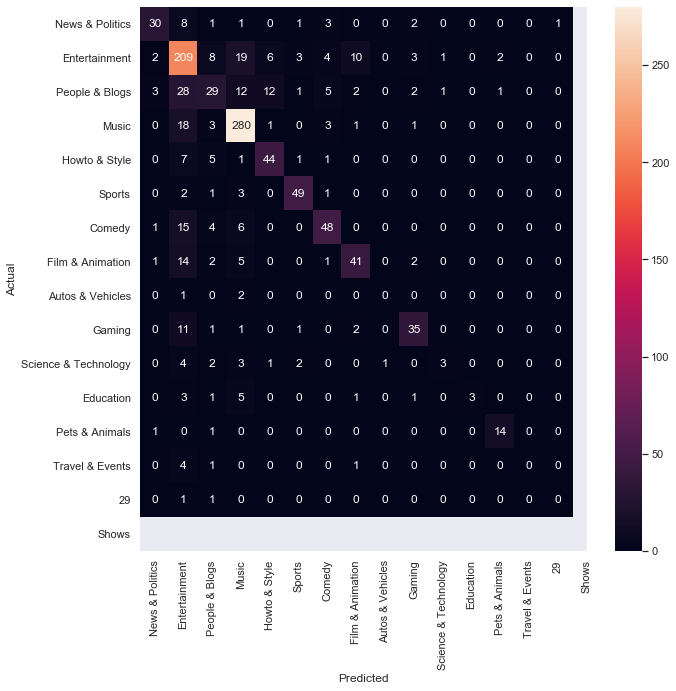

In [77]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_ylim(16.0, 0)
plt.show()

## Let's test out the classification!

In [86]:
text = ["this is not clickbait"]
text_features = tfidf.transform(text)
predictions = model.predict(text_features)
for text, predicted in zip(text, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"this is not clickbait"
  - Predicted as: 'Music'



In [95]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique(), labels=df['_id'].unique()))

                      precision    recall  f1-score   support

     News & Politics       0.79      0.64      0.71        47
       Entertainment       0.64      0.78      0.71       267
      People & Blogs       0.48      0.30      0.37        96
               Music       0.83      0.91      0.87       307
       Howto & Style       0.69      0.75      0.72        59
              Sports       0.84      0.88      0.86        56
              Comedy       0.73      0.65      0.69        74
    Film & Animation       0.71      0.62      0.66        66
    Autos & Vehicles       0.00      0.00      0.00         3
              Gaming       0.76      0.69      0.72        51
Science & Technology       0.60      0.19      0.29        16
           Education       1.00      0.21      0.35        14
      Pets & Animals       0.82      0.88      0.85        16
     Travel & Events       0.00      0.00      0.00         6
                  29       0.00      0.00      0.00         2
       

## I would likely trust this model to Predict Music, Pets or Sports categories. And from our previous analysis, this may pave the way to exploiting the algorithm by entering a video in an "easier to trend" category like Pets & Animals!